In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
import glob,os

## Load SVM model and associated scaling parameters, and feature parameters

In [2]:
import pickle

filename = 'saved_optimal_SVM_model'
svc = pickle.load(open(filename,'rb'))
filename = 'saved_X_scaler'
X_scaler = pickle.load(open(filename,'rb'))
with open('saved_feature_params.pickle', 'rb') as handle:
    feature_params = pickle.load(handle)

colorspace = feature_params['colorspace']
orient = feature_params['orient']
pix_per_cell = feature_params['pix_per_cell']
cell_per_block = feature_params['cell_per_block']
hog_channel = feature_params['hog_channel']
spatial_feat = feature_params['spatial_feat']
hist_feat = feature_params['hist_feat']
hog_feat = feature_params['hog_feat']

Convert to different colorspace as found by the classifier

In [3]:
def convert_color(img, convTo='YCrCb'):
    if convTo == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif convTo == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif convTo == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif convTo == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif convTo == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = image
    return feature_image

Feature generation functions

In [17]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
                        
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins = nbins)
    channel2_hist = np.histogram(img[:,:,1], bins = nbins)
    channel3_hist = np.histogram(img[:,:,2], bins = nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

Extract of the find_cars function from the lecture videos to check the bounding boxes for classification

In [18]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def draw_windows(img, ystart, ystop, scale, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB')
    ctrans_tosearch = img_tosearch
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                   
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

Function to check the bounding boxes and choose suitable ones

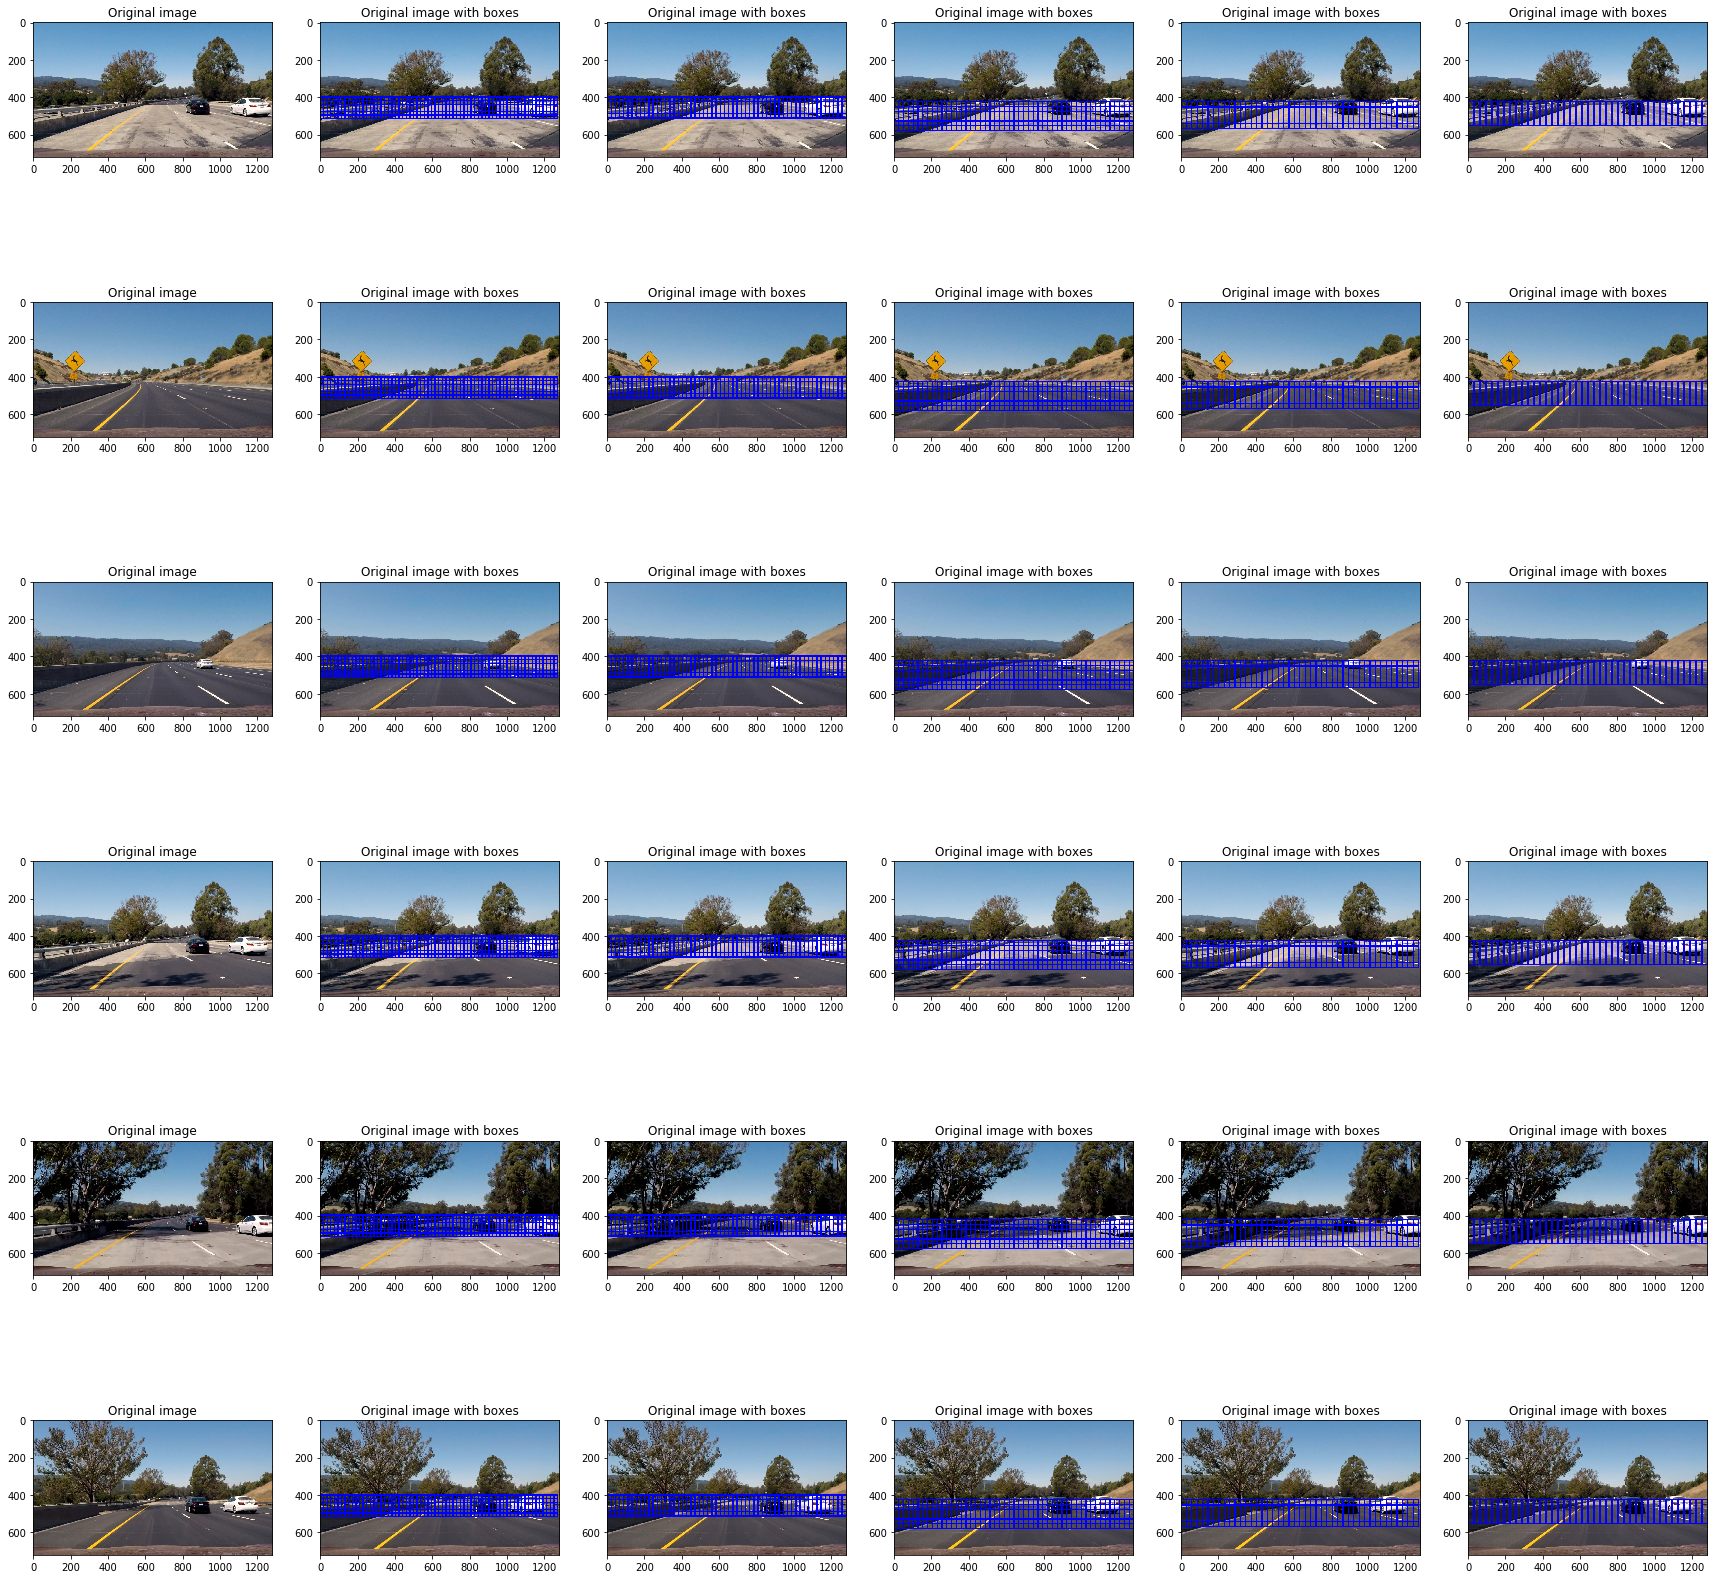

In [19]:
path = 'C:/Users/AVIK/Documents/Udacity Self Driving Cars/CarND-Vehicle-Detection-master/test_images'
test_images = glob.glob(path+'/*.jpg')
fig, axs = plt.subplots(6,6, figsize=(30,30))
axs = axs.ravel()

for ii in range(len(test_images)):
    image = plt.imread(test_images[ii])
    axs[6*ii].imshow(image)
    axs[6*ii].set_title('Original image')
    draw_img = draw_windows(image, 400, 520, 1.2, pix_per_cell, cell_per_block)
    axs[6*ii+1].imshow(draw_img)
    axs[6*ii+1].set_title('Original image with boxes')
    draw_img = draw_windows(image, 400, 520, 1.4, pix_per_cell, cell_per_block)
    axs[6*ii+2].imshow(draw_img)
    axs[6*ii+2].set_title('Original image with boxes')
    draw_img = draw_windows(image, 425, 580, 1.6, pix_per_cell, cell_per_block)
    axs[6*ii+3].imshow(draw_img)
    axs[6*ii+3].set_title('Original image with boxes')
    draw_img = draw_windows(image, 425, 580, 1.8, pix_per_cell, cell_per_block)
    axs[6*ii+4].imshow(draw_img)
    axs[6*ii+4].set_title('Original image with boxes')
    draw_img = draw_windows(image, 425, 580, 2.0, pix_per_cell, cell_per_block)
    axs[6*ii+5].imshow(draw_img)
    axs[6*ii+5].set_title('Original image with boxes')

The find_cars function from the lectures with minor tweaks as required by my function

In [55]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace, spatial_size=(32, 32), hist_bins=32):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
        
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, colorspace)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    #nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap,b  define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog_feat1
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            features_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(features_stacked)    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
                
    return bboxes

Function to choose the bounding boxes that classify vehicles

In [48]:
def vehicle_detect(image):
    overall_boxes = []
    bboxes = find_cars(image, 400, 520, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace)
    overall_boxes.extend(bboxes)
    bboxes = find_cars(image, 400, 520, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace)
    overall_boxes.extend(bboxes)
    bboxes = find_cars(image, 400, 520, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace)
    overall_boxes.extend(bboxes)
    bboxes = find_cars(image, 425, 580, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace)
    overall_boxes.extend(bboxes)
    bboxes = find_cars(image, 425, 580, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, colorspace)
    overall_boxes.extend(bboxes)
    
    return overall_boxes

Here is where I am stuck. The find_cars function is choosing bounding boxes beyond the specified y_stop parameter. Also all the bounding boxes have positive detection of vehicle although my classifier has 98.4% accuracy 

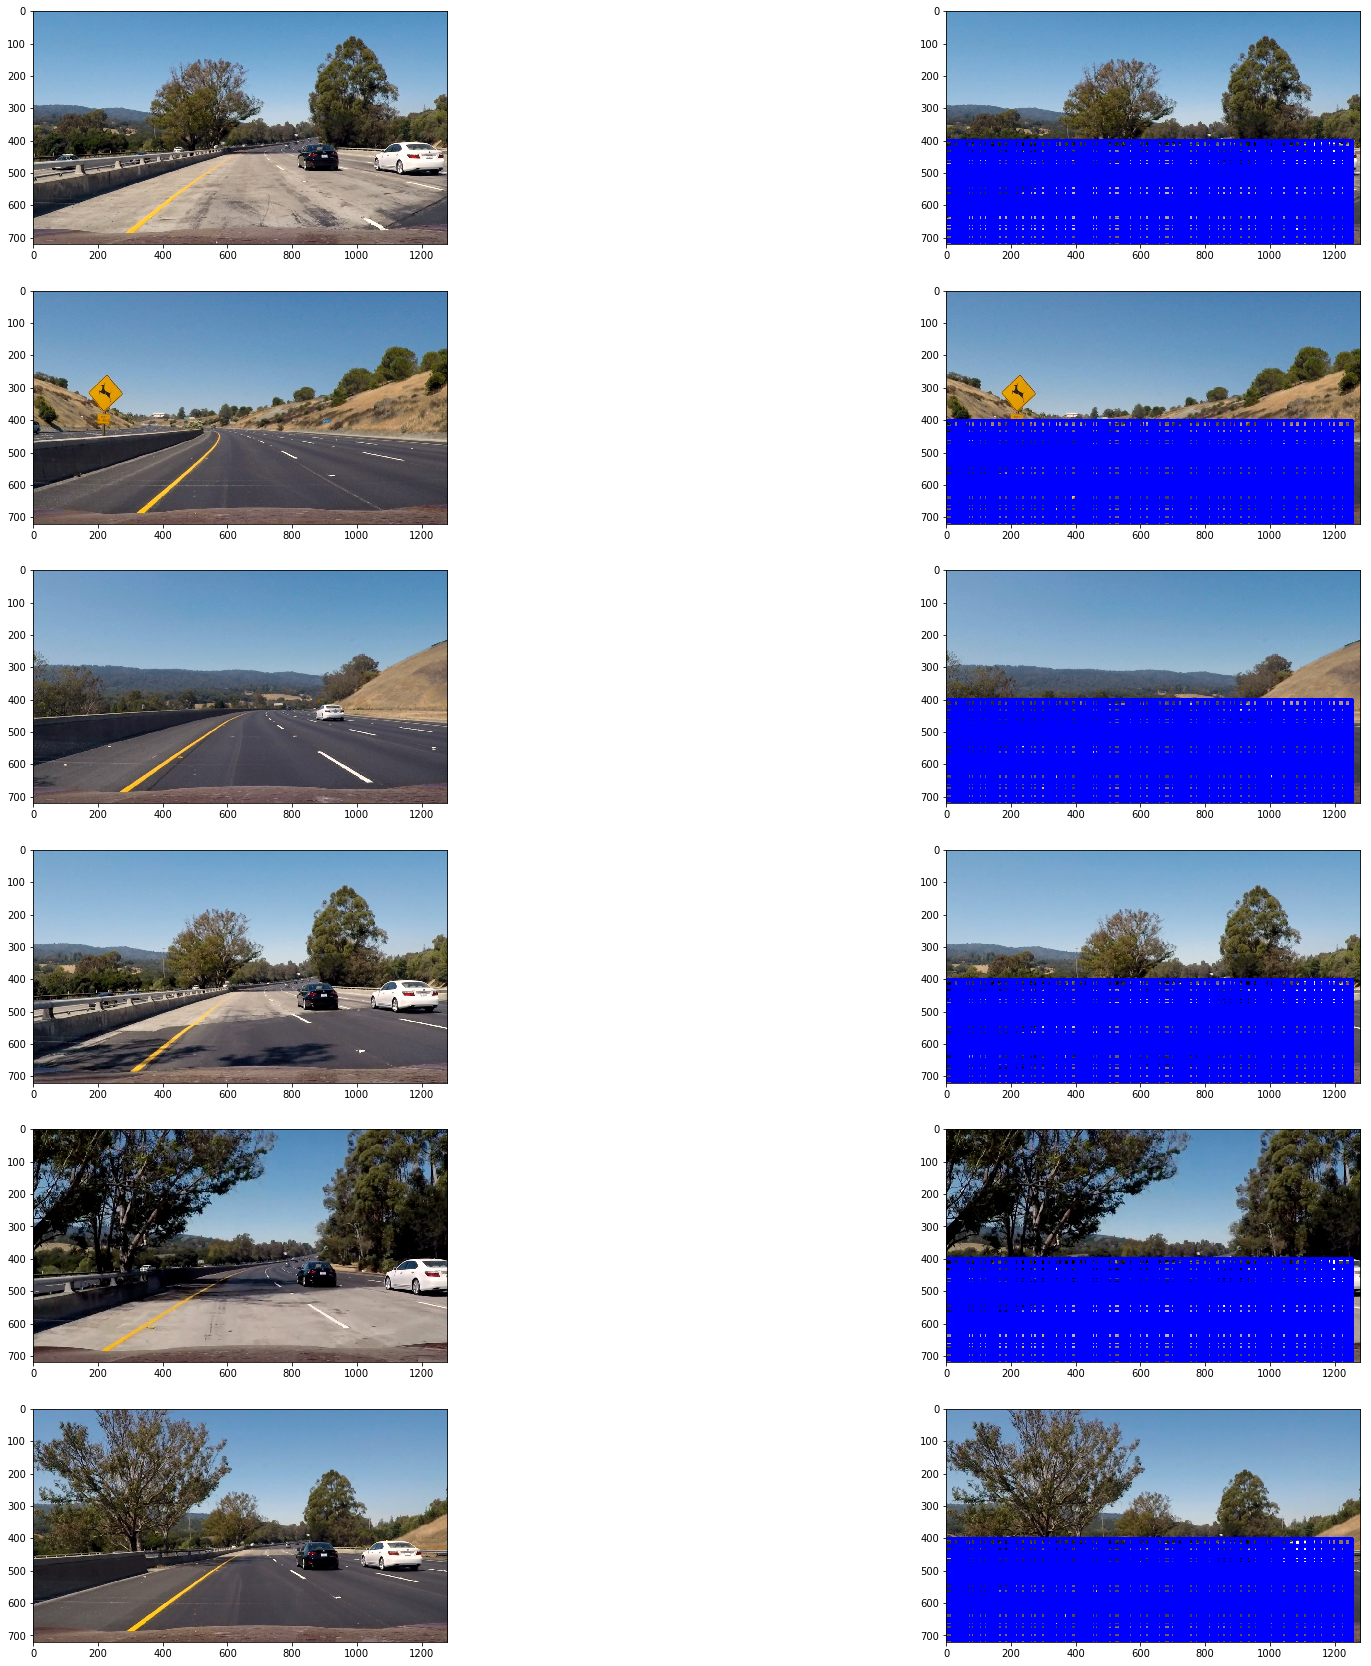

In [49]:
path = 'test_images'
test_images = glob.glob(path+'/*.jpg')
fig, axs = plt.subplots(len(test_images),2, figsize=(30,30))
axs = axs.ravel()

for ii in range(len(test_images)):
    image = plt.imread(test_images[ii])
    detected_image = np.copy(image)
    axs[2*ii].imshow(image)
    overall_boxes = vehicle_detect(image)
    axs[2*ii+1].imshow(draw_img)
    for jj in range(len(overall_boxes)):
        cv2.rectangle(detected_image,overall_boxes[jj][0],overall_boxes[jj][1],(0,0,255),6) 
    axs[2*ii+1].imshow(detected_image)
        

Function to generate the heatmap as explained in the lectures and finally detect

In [50]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,255,255), 6)
    # Return the image
    return img

Function to generate the final bounding box around the detected vehicles

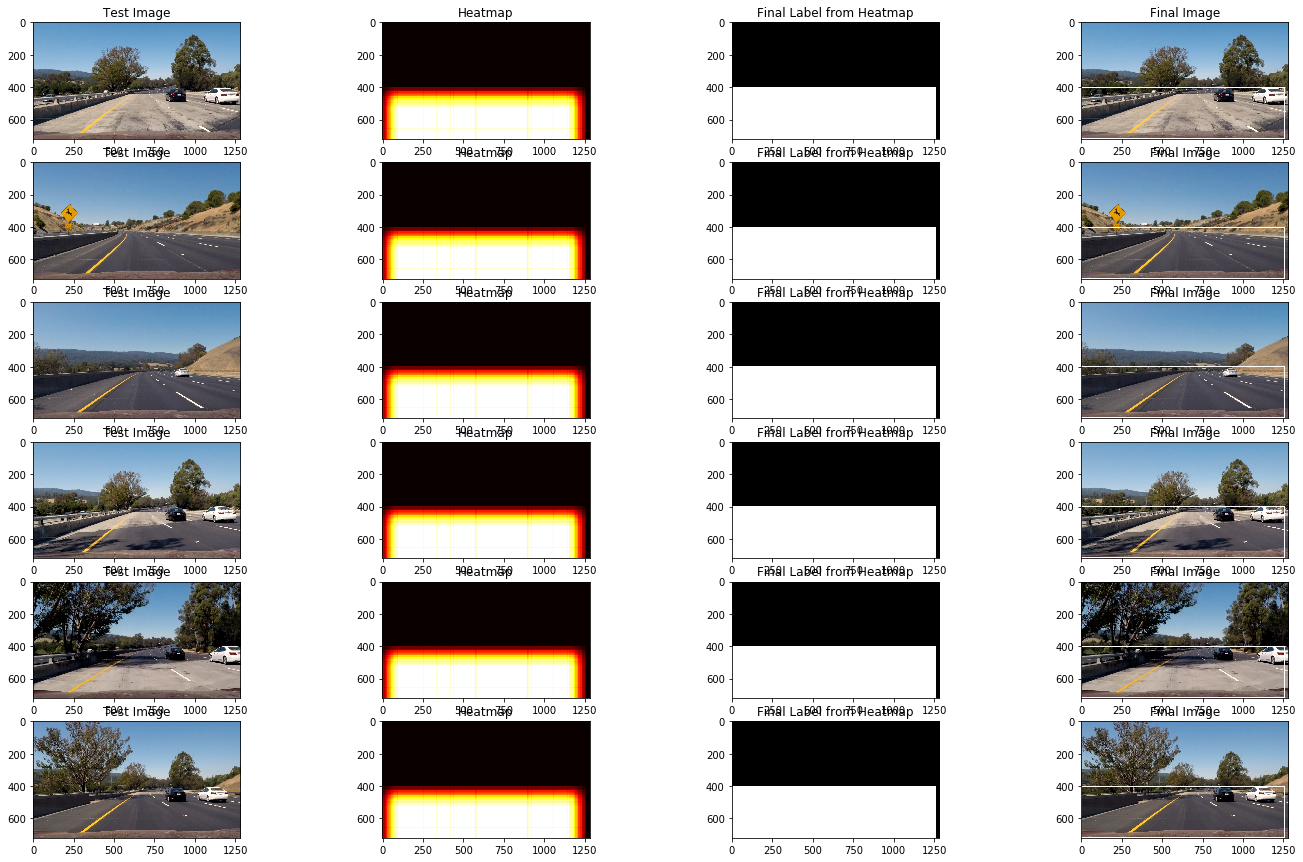

In [51]:
from scipy.ndimage.measurements import label

def get_heatmap(output_image, bboxes):
    threshold = 1
    heat = np.zeros_like(output_image[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    return heatmap

fig, axs = plt.subplots(6,4, figsize=(24,15))
axs = axs.ravel()
for ii in range(len(test_images)):
    image = plt.imread(test_images[ii])
    axs[4*ii].imshow(image)
    axs[4*ii].set_title("Test Image")
    overall_boxes = vehicle_detect(image)
    heatmap = get_heatmap(image, overall_boxes)
    axs[4*ii+1].imshow(heatmap, cmap='hot')
    axs[4*ii+1].set_title("Heatmap")
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    axs[4*ii+2].imshow(labels[0], cmap='gray')
    axs[4*ii+2].set_title("Final Label from Heatmap")
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    axs[4*ii+3].imshow(draw_img)
    axs[4*ii+3].set_title("Final Image")
